# Mental Health in the Tech Industry Project

# Objective

 The objective of this project is to explore the Mental Health in Tech (years 2014, and 2016-2018) survey data and provide insights of how mental health issues are dealt with in the tech workplace as well as potentially find a further direction for research.

# Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Tables

In [2]:
with sqlite3.connect('mental_health.sqlite') as con:
    print(list(pd.read_sql_query(
        "SELECT name FROM sqlite_master WHERE type='table';", con)['name']))

['Answer', 'Question', 'Survey']


## Schema

In [3]:
print(*list(f'{i} table: {list(pd.read_sql_query(f"SELECT * FROM {i}", con).columns)}'
        for i in 'Answer, Question, Survey'.split(',')), sep='\n')

Answer table: ['AnswerText', 'SurveyID', 'UserID', 'QuestionID']
 Question table: ['questiontext', 'questionid']
 Survey table: ['SurveyID', 'Description']


In [4]:
list(pd.read_sql_query("SELECT * FROM Question", con).questiontext)

['What is your age?',
 'What is your gender?',
 'What country do you live in?',
 'If you live in the United States, which state or territory do you live in?',
 'Are you self-employed?',
 'Do you have a family history of mental illness?',
 'Have you ever sought treatment for a mental health disorder from a mental health professional?',
 'How many employees does your company or organization have?',
 'Is your employer primarily a tech company/organization?',
 'Does your employer provide mental health benefits as part of healthcare coverage?',
 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
 'Would you bring up a mental health issue with a potential employer in an interview?',
 'Is your primary role within your company related to tech/IT?',
 'Do you know the options for mental health care available under your employer-provided health coverage?',
 'Has your employer ever formally discussed men

## Reading the Database

In [5]:
def read_query(year):   
    """
    Reads the query for a specified year into a pandas DataFrame.
    """
    return pd.DataFrame(pd.read_sql_query(
    f"""
    SELECT Question.questiontext, Answer.AnswerText, Answer.UserID
    FROM Answer 
    JOIN Question 
    ON Answer.QuestionID = Question.questionid
    WHERE Answer.SurveyID = {year}
    """, con))

def make_df(year):
    """
    Invokes the read_query function and groups the output by UserID
    """
    data_frame = read_query(year)
    data_frame_grouped = data_frame.groupby('UserID')
    return pd.concat([data_frame_grouped.get_group(i).drop_duplicates('questiontext').pivot(
    index='UserID', columns='questiontext', values='AnswerText') for i in data_frame['UserID'].unique()])

survey_2014 = make_df(2014)
survey_2016 = make_df(2016)
survey_2017 = make_df(2017)
survey_2018 = make_df(2018)

survey_2014.head()

questiontext,Any additional notes or comments,Are you self-employed?,Do you feel that your employer takes mental health as seriously as physical health?,Do you have a family history of mental illness?,Do you know the options for mental health care your employer provides?,Do you think that discussing a mental health issue with your employer would have negative consequences?,Do you think that discussing a physical health issue with your employer would have negative consequences?,Do you work remotely (outside of an office) at least 50% of the time?,Does your employer provide mental health benefits as part of healthcare coverage?,Does your employer provide resources to learn more about mental health issues and how to seek help?,...,"If you live in the United States, which state or territory do you live in?",Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,Is your employer primarily a tech company/organization?,What country do you live in?,What is your age?,What is your gender?,Would you be willing to discuss a mental health issue with your coworkers?,Would you be willing to discuss a mental health issue with your direct supervisor(s)?,Would you bring up a mental health issue with a potential employer in an interview?,Would you bring up a physical health issue with a potential employer in an interview?
UserID,,,,,,,,,,,,,,,,,,,,,
1,-1,-1,Yes,No,Not sure,No,No,No,Yes,Yes,...,Illinois,Yes,1,United States,37,Female,Some of them,Yes,No,Maybe
2,-1,-1,Don't know,No,No,Maybe,No,No,Don't know,Don't know,...,Indiana,Don't know,0,United States,44,Male,No,No,No,No
3,-1,-1,No,No,No,No,No,No,No,No,...,-1,Don't know,1,Canada,32,Male,Yes,Yes,Yes,Yes
4,-1,-1,No,Yes,Yes,Yes,Yes,No,No,No,...,-1,No,1,United Kingdom,31,Male,Some of them,No,Maybe,Maybe
5,-1,-1,Don't know,No,No,No,No,Yes,Yes,Don't know,...,Texas,Don't know,1,United States,31,Male,Some of them,Yes,Yes,Yes


# EDA

## Gender and Mental Health

Note: The survey from 2014 didn't feature a question, whether someone has a mental health disorder, therefore that survey was not used.

In [6]:
def assign_gender(x):
    if not x == '-1':
        if x.lower().strip() == 'male':
            return 'Male'
        elif x.lower().strip() == 'female':
            return 'Female'
        else:
            return 'Other'
            
age_gender_race_df = pd.concat([survey_2016, survey_2017, survey_2018])[
['Do you currently have a mental health disorder?','What is your age?',
 'What is your gender?', 'What is your race?']]
age_gender_race_df['gender'] = age_gender_race_df[
'What is your gender?'].apply(assign_gender)

In [7]:
age_gender_race_df['gender'].isna().sum()

19

In [8]:
list(age_gender_race_df['Do you currently have a mental health disorder?'].unique())

['No', 'Yes', 'Maybe', 'Possibly', "Don't Know"]

In [9]:
age_gender_race_df['Do you currently have a mental health disorder?'].isna().any()

False

In [10]:
age_gender_race_df.columns = ['Has MHD', 'Age','x','Race', 'Gender']
age_gender_race_df.drop('x', axis=1, inplace=True)

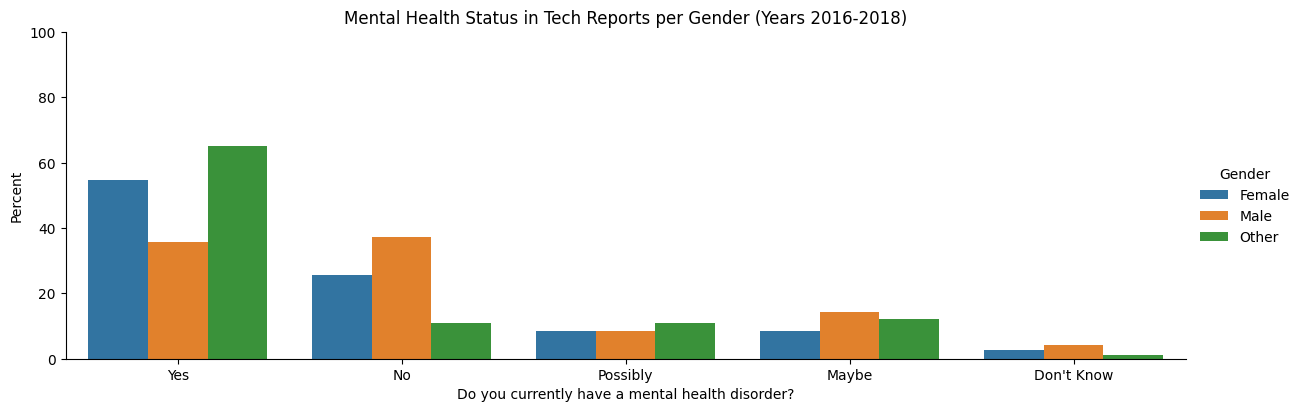

In [11]:
(
  age_gender_race_df
 .groupby('Gender')['Has MHD']
 .value_counts(normalize=True)
 .mul(100)
 .reset_index()
 .pipe((sns.catplot,'data'), x='Has MHD', 
       y='proportion', hue='Gender', kind='bar', height=4, aspect=3)
    .set(ylim=(0, 100))
    .set_axis_labels("Do you currently have a mental health disorder?", "Percent")
)
plt.gca().set_title('Mental Health Status in Tech Reports per Gender (Years 2016-2018)');

Generally women and other gender denominations report higher levels of mental health disorder diagnoses.

## Mental Health Reports per Age Group

In [12]:
age_gender_race_df['Age'].isna().any()

False

In [13]:
(len(age_gender_race_df[age_gender_race_df['Age'] == '-1']) / len(age_gender_race_df['Age'])) * 100

0.07674597083653108

Missing values constitute a very small proportion of data

In [14]:
age_gender_race_df.drop(age_gender_race_df[age_gender_race_df['Age'] == '-1'].index, inplace=True)

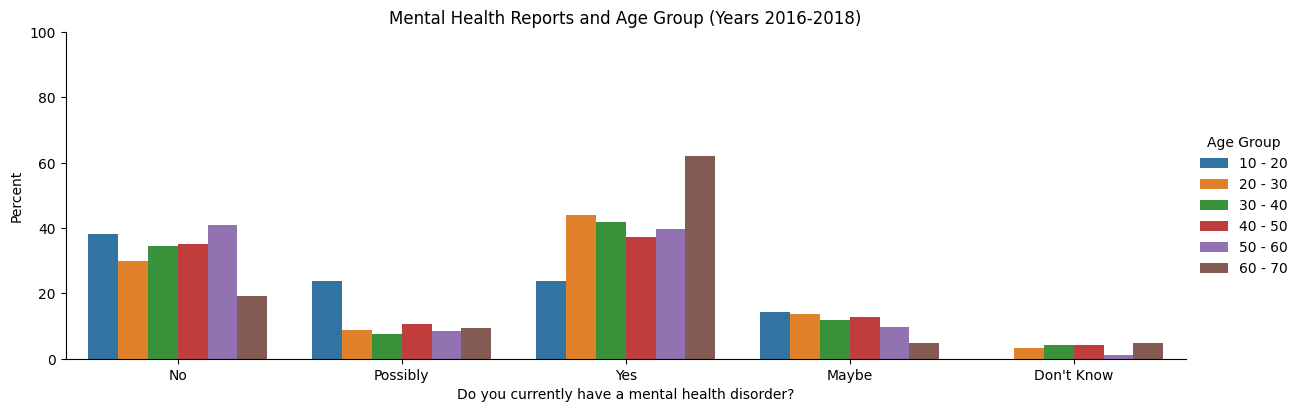

In [15]:
age_gender_race_df['Age Group'] = (pd.cut(age_gender_race_df['Age']
                                        .astype(int), np.linspace(10, 100, 10, dtype=int))
                                 .astype(str)
                                 .str.strip('(]')
                                 .str.replace(', ', ' - ')
                                )

(
 age_gender_race_df.groupby('Age Group')['Has MHD']
 .value_counts(normalize=True)
 .mul(100)
 .reset_index()
 .drop(list(range(29, 33)))
 .pipe((sns.catplot,'data'), x='Has MHD', 
       y='proportion', hue='Age Group', kind='bar', height=4, aspect=3)
    .set(ylim=(0, 100))
    .set_axis_labels("Do you currently have a mental health disorder?", "Percent")
)
plt.gca().set_title('Mental Health Reports and Age Group (Years 2016-2018)');

In [16]:
pd.DataFrame(age_gender_race_df['Age Group'].value_counts()).T

Age Group,30 - 40,20 - 30,40 - 50,50 - 60,10 - 20,60 - 70,nan,90 - 100,70 - 80
count,1142,912,411,93,21,21,2,1,1


90-100 and 70-80 age groups were dropped. 10-20 and 60-70 the sample size is likely insufficient for any meaningful results thus the results seem to lie outside the trend. Generally the probability of each answer seems to be similar among all age groups.

## Mental Health Reports and Race

In [17]:
age_gender_race_df['Race'].notna().sum()

1171

There are no entries for race for year 2016. Therefore only the data from 2017 and 2018 will be used.

In [18]:
age_gender_race_df_2017_2018 = age_gender_race_df.drop(list(range(1261, 2694)))

In [19]:
len(age_gender_race_df_2017_2018[age_gender_race_df_2017_2018['Race'] == '-1']) / len(age_gender_race_df_2017_2018['Race'])

0.3304867634500427

The third of the race data from years 2017 and 2018 is missing. Nevertheless, it would be interesting to look at it, even in the case where results should be taken with a big grain of salt.

In [20]:
age_gender_race_df_2017_2018.drop(
    index=age_gender_race_df_2017_2018[
    age_gender_race_df_2017_2018['Race'] == '-1'].index,
    inplace=True)

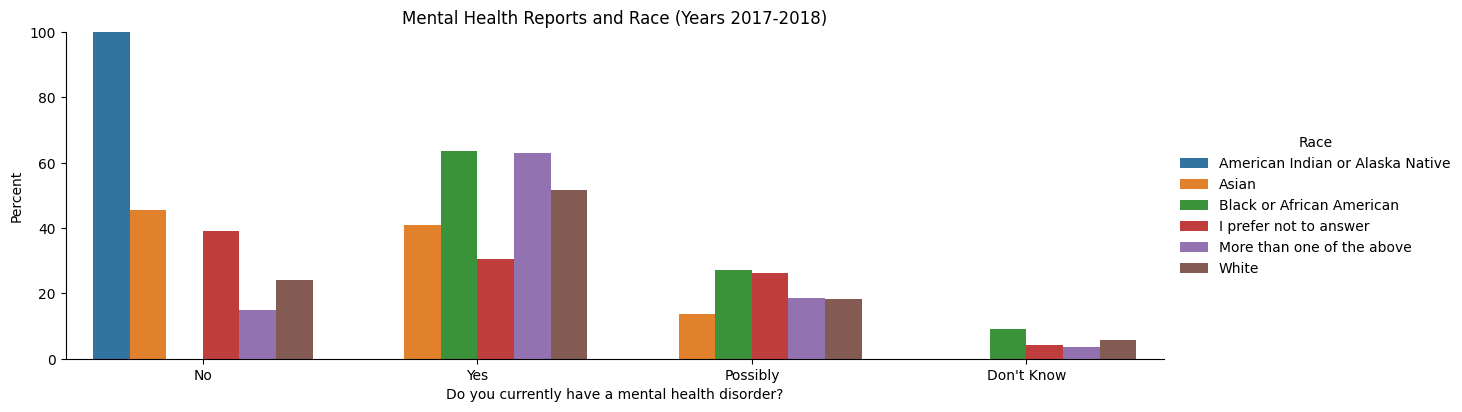

In [21]:
(age_gender_race_df_2017_2018
 .groupby('Race')['Has MHD']
 .value_counts(normalize=True)
 .mul(100)
 .reset_index()
 .pipe((sns.catplot,'data'), x='Has MHD', 
       y='proportion', hue='Race', kind='bar', height=4, aspect=3)
    .set(ylim=(0, 100))
    .set_axis_labels("Do you currently have a mental health disorder?", "Percent")
)
plt.gca().set_title('Mental Health Reports and Race (Years 2017-2018)');

In [22]:
pd.DataFrame((age_gender_race_df_2017_2018
 .groupby('Race')['Has MHD']
 .value_counts())).T

Race    American Indian or Alaska Native Asian               \
Has MHD                               No    No Yes Possibly   
count                                  1    10   9        3   

Race    Black or African American                     I prefer not to answer  \
Has MHD                       Yes Possibly Don't Know                     No   
count                           7        3          1                      9   

Race                            More than one of the above              \
Has MHD Yes Possibly Don't Know                        Yes Possibly No   
count     7        6          1                         17        5  4   

Race               White                           
Has MHD Don't Know   Yes   No Possibly Don't Know  
count            1   361  169      129         41

Very few entries, therefore, the results are very unreliable.

## Self-Employment

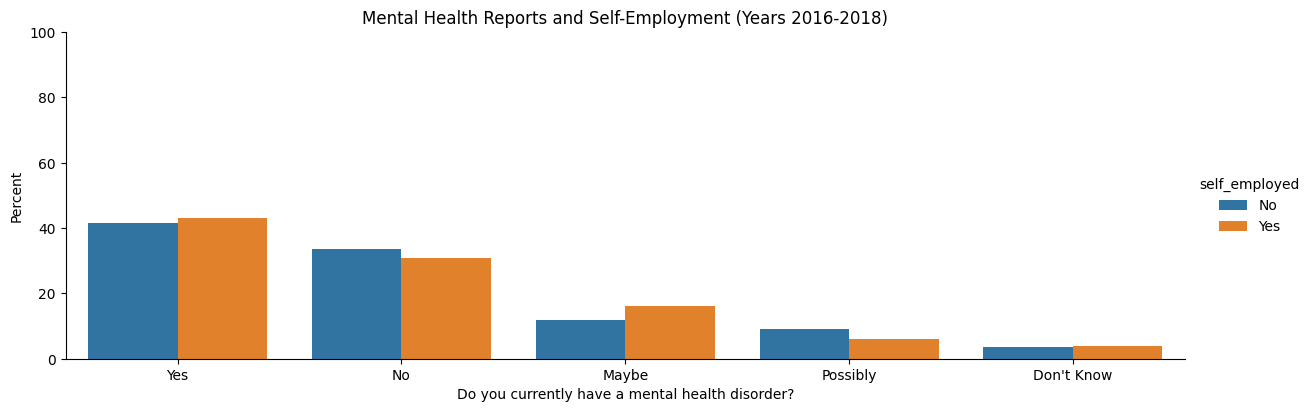

In [23]:
self_employed = pd.concat([survey_2016, survey_2017, survey_2018])[
['Are you self-employed?', "Do you currently have a mental health disorder?"]]
(self_employed
 .assign(self_employed=self_employed['Are you self-employed?']
         .apply(lambda x: 'Yes' if x == '1' else 'No'))
 .groupby('Are you self-employed?')
 .value_counts(normalize=True)
 .mul(100)
 .reset_index()
 .pipe((sns.catplot,'data'), x='Do you currently have a mental health disorder?', 
       y='proportion', hue='self_employed', kind='bar', height=4, aspect=3)
    .set(ylim=(0, 100))
    .set_axis_labels("Do you currently have a mental health disorder?", "Percent")
)
plt.gca().set_title('Mental Health Reports and Self-Employment (Years 2016-2018)');

Generally, very similar trends.

## Sentiments on Being Labeled Having a MHD

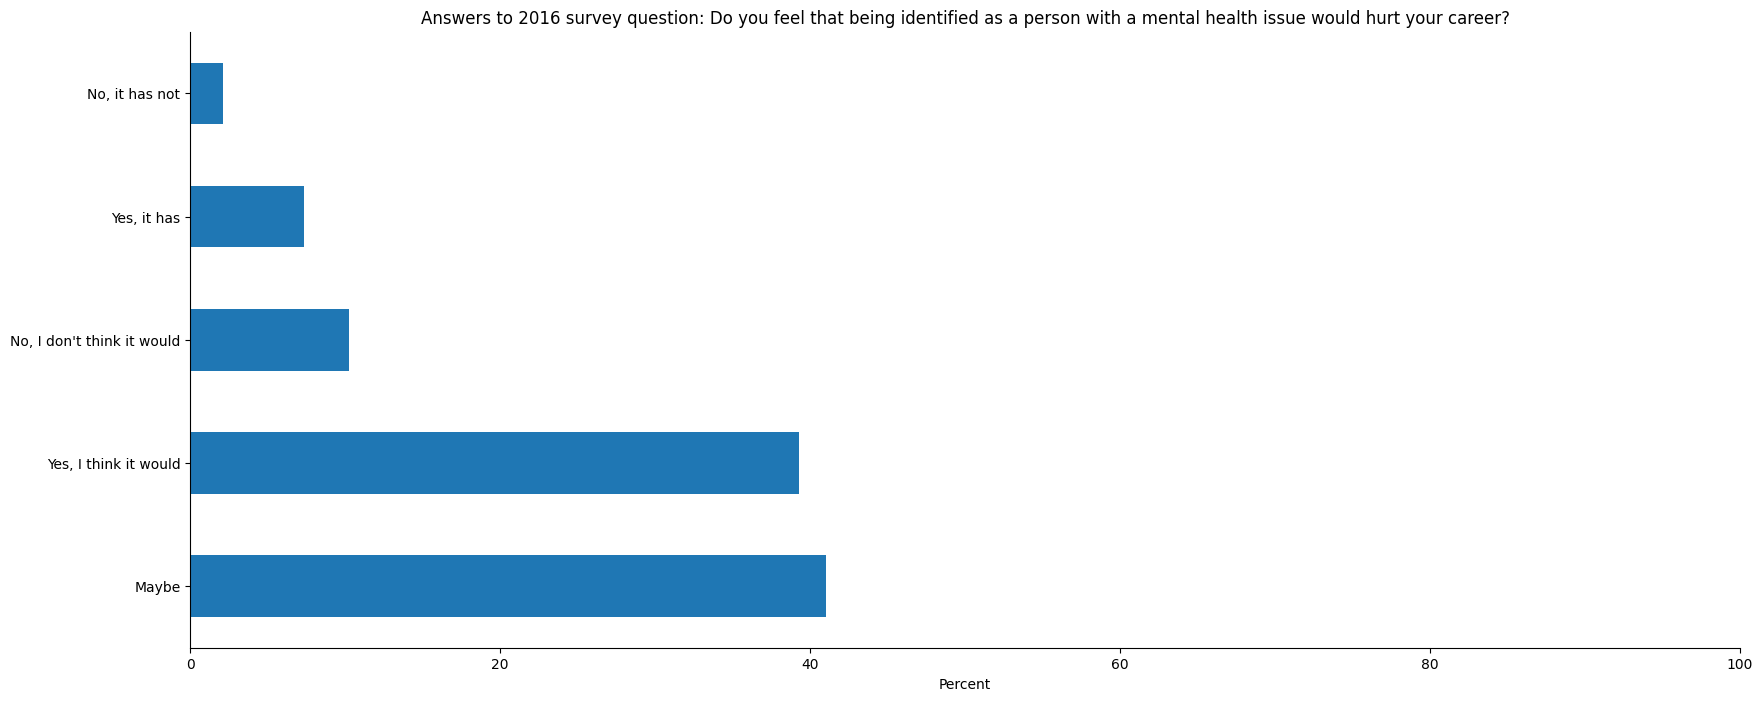

In [24]:
(survey_2016["Do you feel that being identified as a person with a mental health issue would hurt your career?"]
 .value_counts(normalize=True)
 .mul(100)
 .plot(kind='barh', figsize=(20, 8))
)

ax=plt.gca()
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlim(0, 100)
ax.set_title(f'Answers to 2016 survey question: {ax.get_ylabel()}')
ax.set_ylabel('')
ax.set_xlabel('Percent');

Most of the respondents think that being label with a mental illness would hurt their careers or are not sure about it.

## Bringing Up Mental Health in an Interview

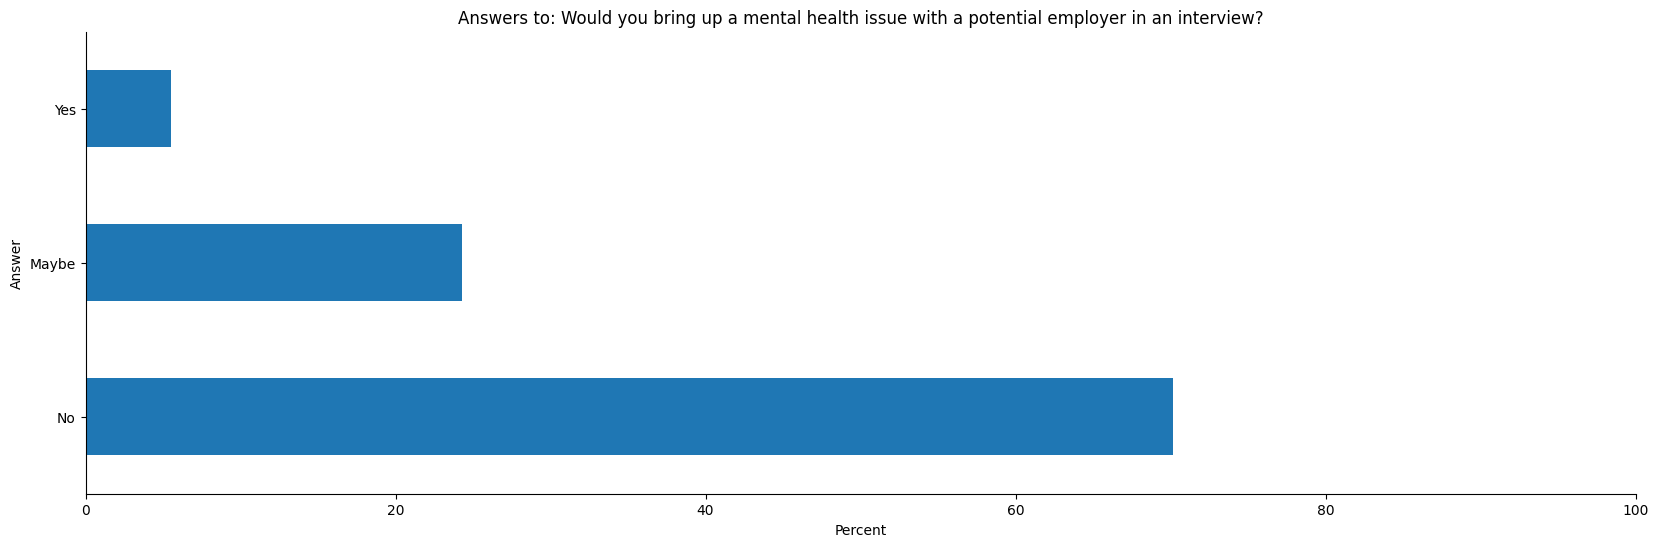

In [25]:
(pd.concat([survey_2014['Would you bring up a mental health issue with a potential employer in an interview?'],
          survey_2016['Would you bring up a mental health issue with a potential employer in an interview?'],
          survey_2017['Would you bring up a mental health issue with a potential employer in an interview?'],
          survey_2018['Would you bring up a mental health issue with a potential employer in an interview?']])
 .value_counts(normalize=True)
 .mul(100)
 .plot(kind='barh', xlim=(0,100), figsize=(20,6))
)
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
ax.set_title(f'Answers to: {ax.get_ylabel()}')
ax.set_xlabel('Percent')
ax.set_ylabel('Answer');

Since, this question is a part of all of the surveys in the database, it's possible to compare the answers over time.

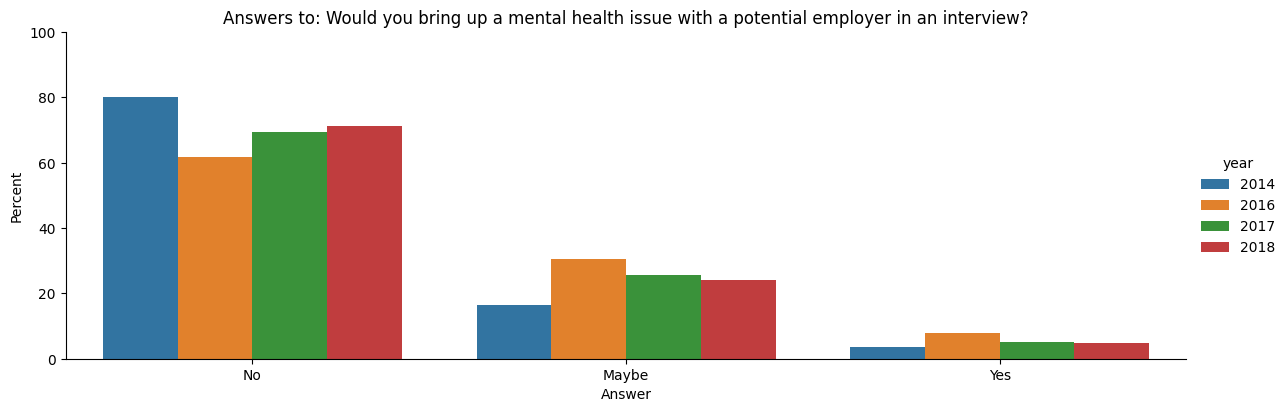

In [26]:
(pd.concat([(pd.DataFrame(survey_2014['Would you bring up a mental health issue with a potential employer in an interview?'])
            .assign(year='2014')),
          (pd.DataFrame(survey_2016['Would you bring up a mental health issue with a potential employer in an interview?'])
                       .assign(year='2016')),
          (pd.DataFrame(survey_2017['Would you bring up a mental health issue with a potential employer in an interview?'])
                       .assign(year='2017')),
          (pd.DataFrame(survey_2018['Would you bring up a mental health issue with a potential employer in an interview?'])
                        .assign(year='2018'))])
 .groupby('year')
 .value_counts(normalize=True)
 .mul(100)
 .reset_index()
 .pipe((sns.catplot,'data'), x='Would you bring up a mental health issue with a potential employer in an interview?', 
       y='proportion', hue='year', kind='bar', height=4, aspect=3)
    .set(ylim=(0, 100))
    .set_axis_labels("Answer", "Percent")
)
plt.gca().set_title('Answers to: Would you bring up a mental health issue with a potential employer in an interview?');

There is a somewhat sizeable dip in No's and rise in Maybe's and Yes' from 2014 to 2016. It would be interesting to look at older data for this reason. However from 2016 to 2018 interview atendees seem to be increasingly less trustful to mention any mental health problems in an interview.

## Mental Health and Communication

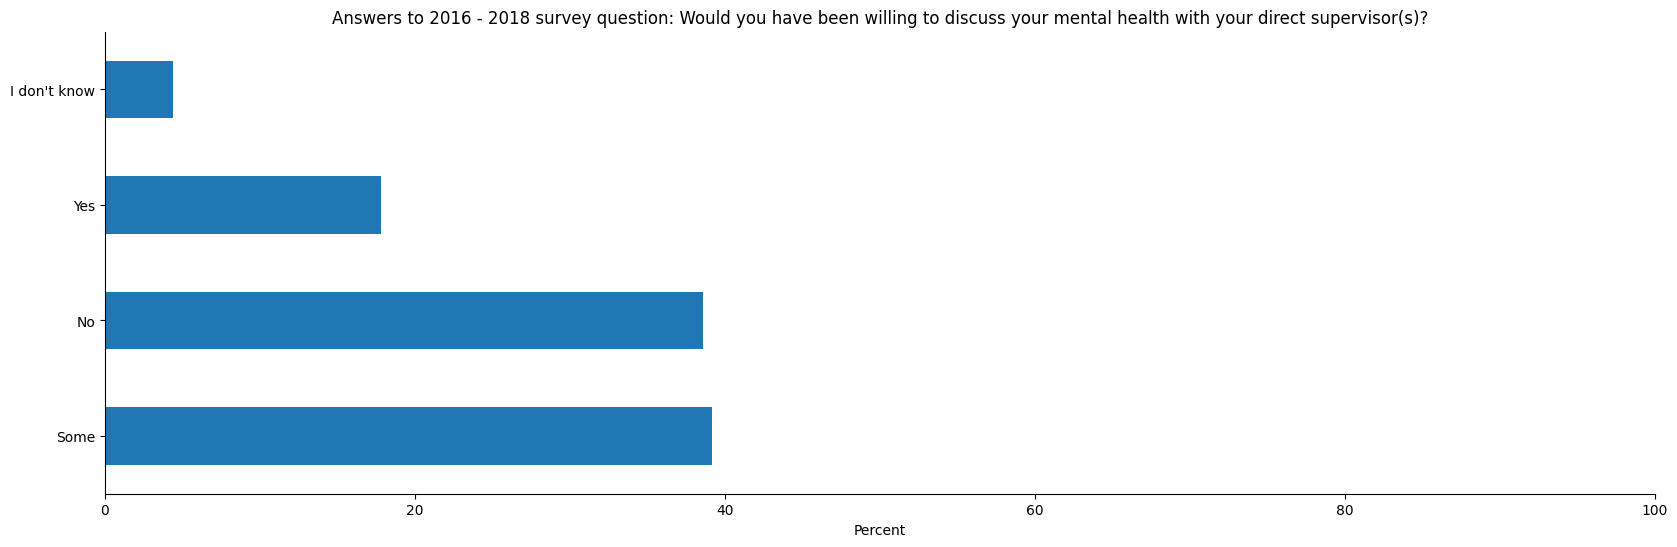

In [27]:
def willing_to_discuss_naming(x):
    if x == "I don't know":
        return x
    elif 'Yes' in x:
        return 'Yes'
    elif 'Some' in x:
        return 'Some'
    return 'No'

(pd.concat([survey_2014
 .rename(columns={
    'Would you be willing to discuss a mental health issue with your direct supervisor(s)?'
    :'Would you have been willing to discuss your mental health with your direct supervisor(s)?'}),
    survey_2016,
    survey_2017,
    survey_2018
])['Would you have been willing to discuss your mental health with your direct supervisor(s)?']
 .apply(willing_to_discuss_naming)
 .value_counts(normalize=True)
 .mul(100)
 .plot(kind='barh', figsize=(20, 6))
)
ax=plt.gca()
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlim(0, 100)
ax.set_title(f'Answers to 2016 - 2018 survey question: {ax.get_ylabel()}')
ax.set_ylabel('')
ax.set_xlabel('Percent');

Generally split results but leaning more towards no.

## Effects on Career

Question "Has being identified as a person with a mental health issue affected your career?" or similar has only been a part of 2017 and 2018 survey.

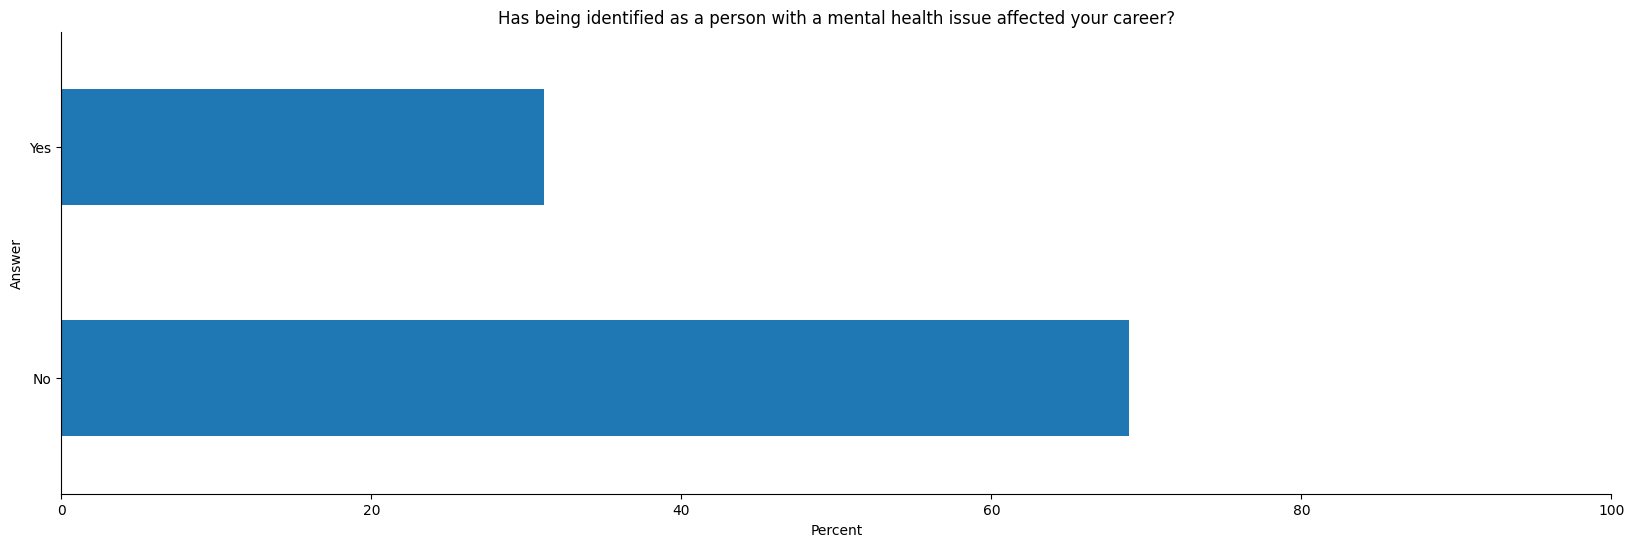

In [28]:
answer_count_effects = (pd.concat([survey_2017, survey_2018])
    ['Has being identified as a person with a mental health issue affected your career?']
    .value_counts()
    .drop('-1')
    .set_axis(['No', 'Yes'])
)

(answer_count_effects / sum(answer_count_effects) * 100).plot(
    kind='barh', figsize=(20,6), xlim=(0,100),
    title='Has being identified as a person with a mental health issue affected your career?')
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('Percent')
ax.set_ylabel('Answer');

Around a third reported that being identified with a mental ilness hindered their carreers.

## Improving Mental Health Support: Employee Suggestions

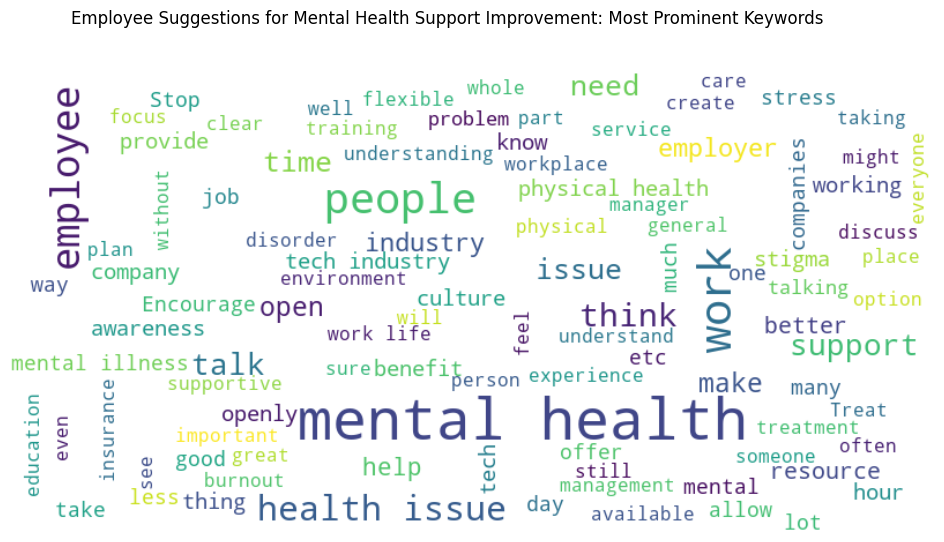

In [29]:
improving_mh = pd.concat([survey_2017[
'Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.'],
                         survey_2018[
'Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.']])
improving_mh

def make_wordcloud(series, title):
    series.drop(series[series == '-1'].index, inplace=True)
    series_strung = " ".join(review for review in series)
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", width=800, height=400).generate(series_strung)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.gcf().set(figheight=6, figwidth=20)
    plt.gcf().suptitle(f'{title}', fontsize=12)
    return plt.show()

make_wordcloud(improving_mh, 'Employee Suggestions for Mental Health Support Improvement: Most Prominent Keywords')

Keywords seem to imply that generally employees think that a lack of mental health awareness and education, good work culture, mental health support are the biggest issues. However more advanced type of analysis is necessary.

## Employee MH Support Opinion Ratings

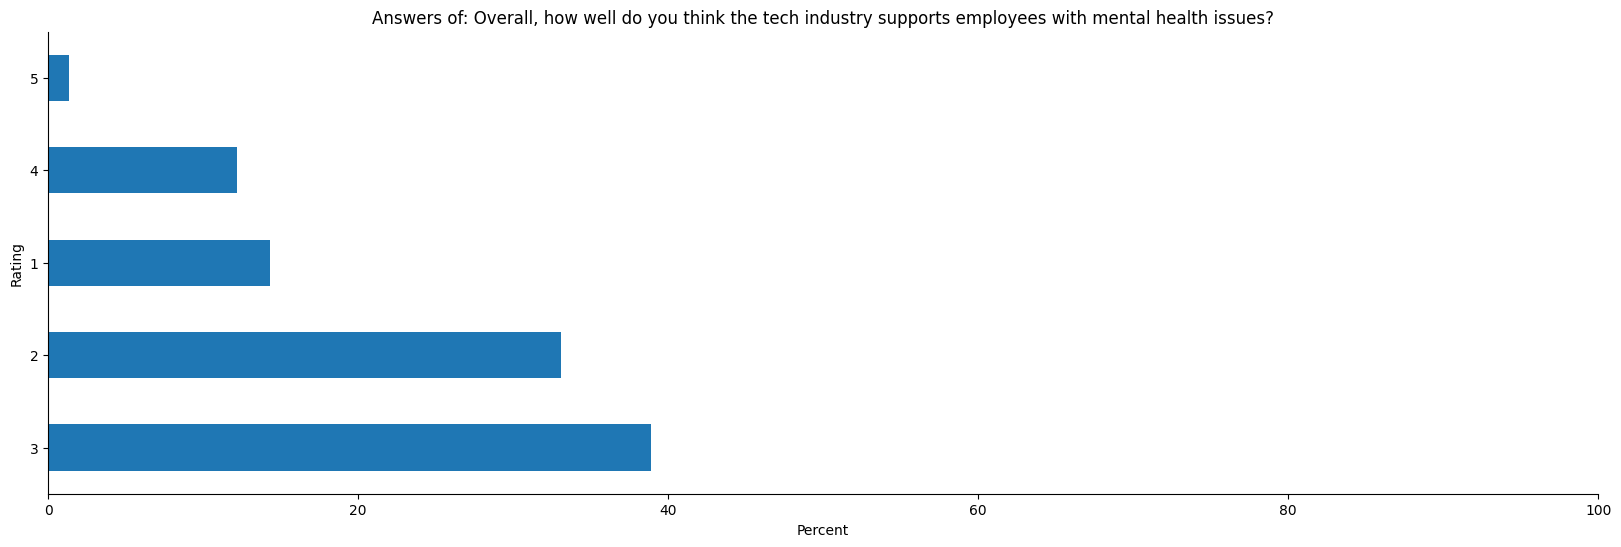

In [30]:
pd.concat([survey_2017['Overall, how well do you think the tech industry supports employees with mental health issues?'],
           survey_2018['Overall, how well do you think the tech industry supports employees with mental health issues?']
          ]).value_counts(normalize=True)[:5].mul(100).plot(kind='barh', figsize=(20,6), xlim=(0,100))
ax = plt.gca()
ax.spines[['top', 'right']].set_visible(False)
ax.set_title(f'Answers of: {ax.get_ylabel()}')
ax.set_xlabel('Percent')
ax.set_ylabel('Rating');

Somewhat low oppinion of MH support in tech.

## MH Condition Reports

Survey of 2016 contains information of MH condition diagnosis.

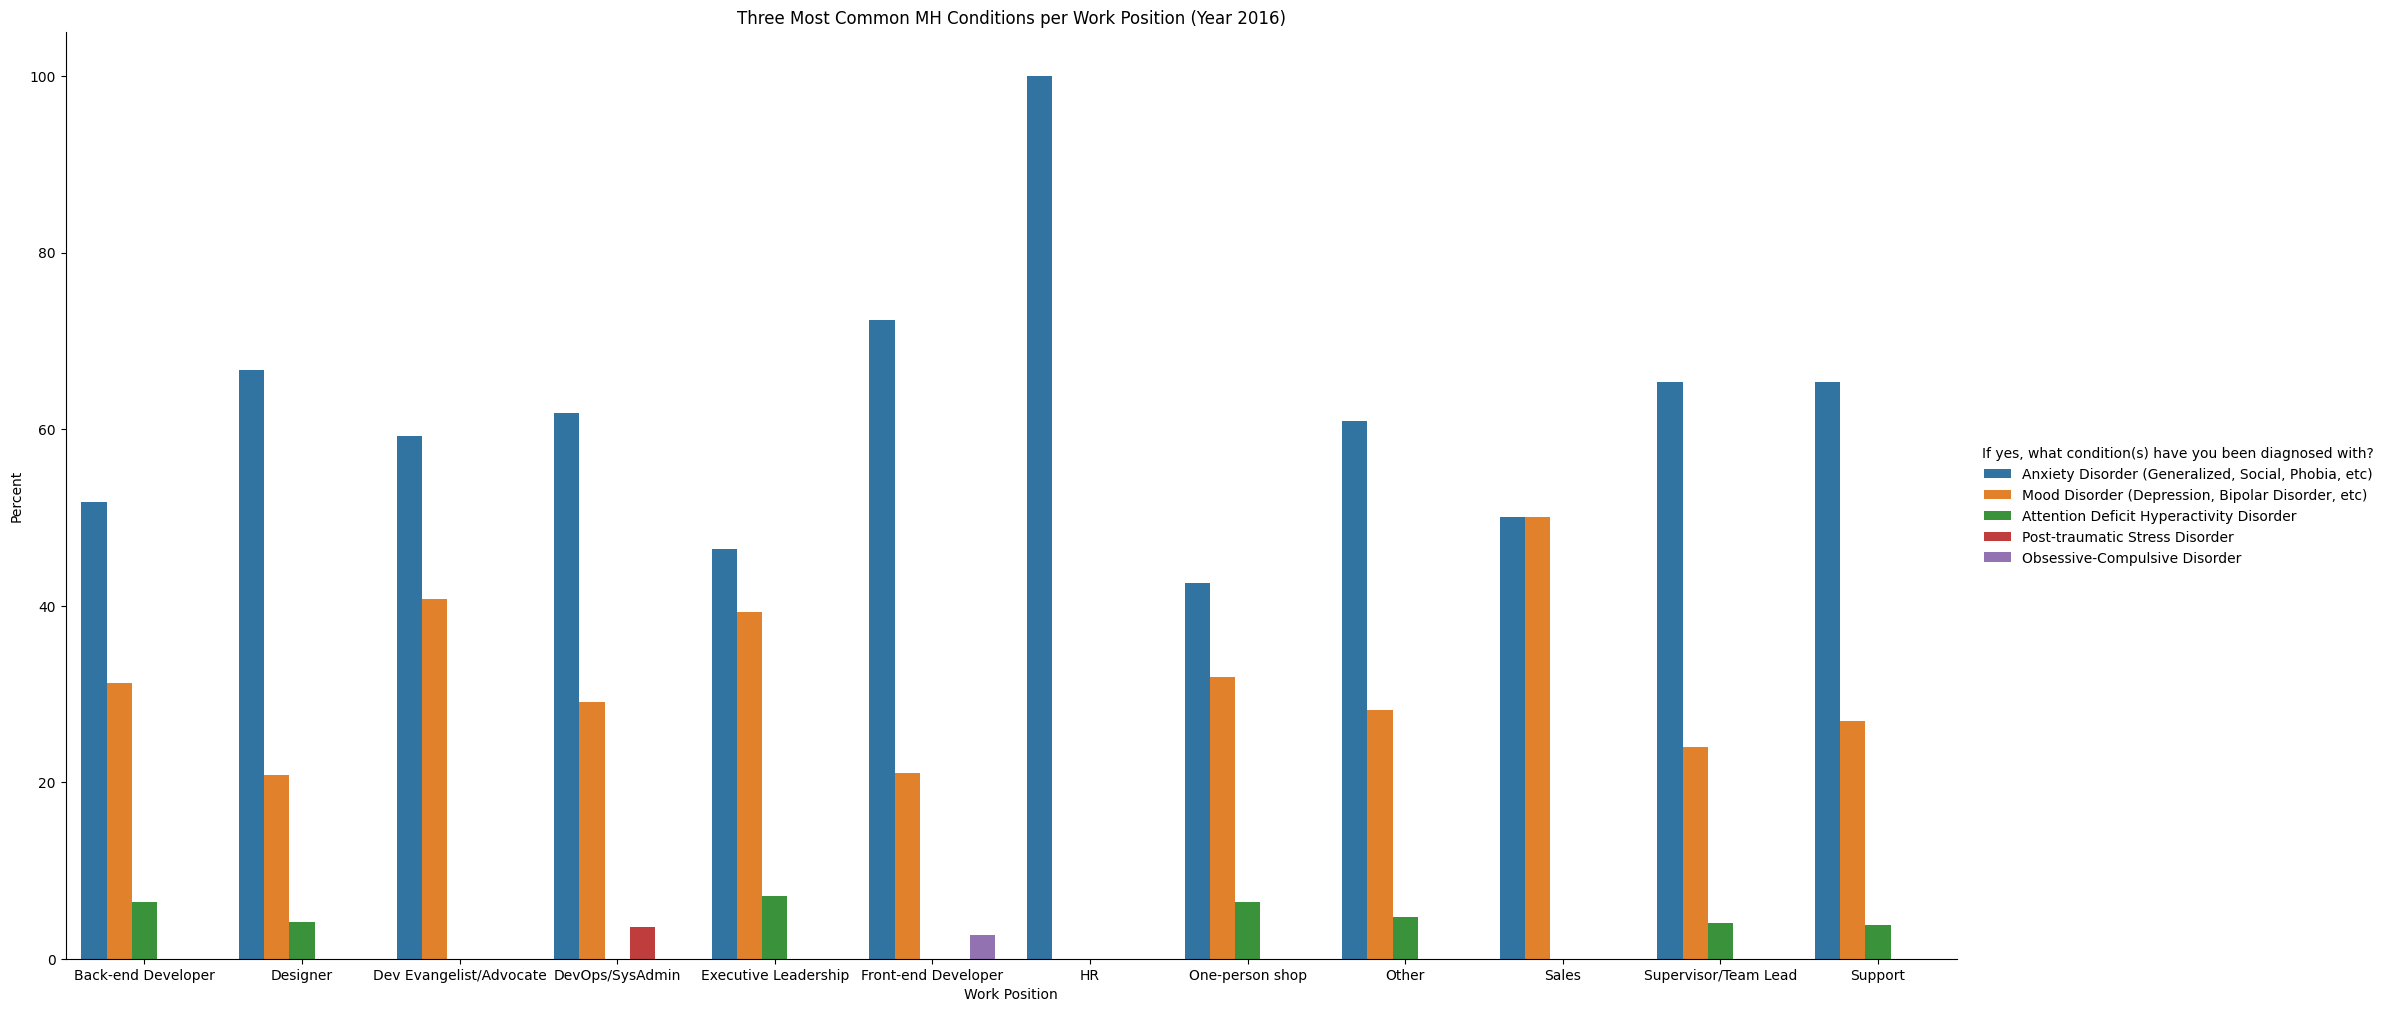

In [31]:
(survey_2016[['If yes, what condition(s) have you been diagnosed with?', 'Which of the following best describes your work position?']]
 .drop(survey_2016[survey_2016['If yes, what condition(s) have you been diagnosed with?'] == '-1'].index)
 .groupby('Which of the following best describes your work position?')
 .value_counts(normalize=True)
 .groupby(level=0)
 .head(3)
 .reset_index()
 .apply(lambda x: x * 100 if x.name == 'proportion' else x)
 .pipe((sns.catplot,'data'), x='Which of the following best describes your work position?', 
       y='proportion', hue='If yes, what condition(s) have you been diagnosed with?',
       kind='bar', height=10, aspect=2)).set_axis_labels("Work Position", "Percent")
plt.gca().set_title('Three Most Common MH Conditions per Work Position (Year 2016)');

In [32]:
(survey_2016[
['If yes, what condition(s) have you been diagnosed with?',
 'Which of the following best describes your work position?']]
 .value_counts()
 .reset_index()
 .query(
'`Which of the following best describes your work position?` == "HR"'))

,"If yes, what condition(s) have you been diagnosed with?",Which of the following best describes your work position?,count
31,-1,HR,4
38,"Anxiety Disorder (Generalized, Social, Phobia,...",HR,3


There are only total of 3 HR survey answers, thus the 100%. Anxiety disorders, followed mood disorders, are overwhelmingly the most common among all of the work positions.

# Conclusions

- Women and people of other gender denominations generally report mental health diagnoses more than men. One possible explanation for this could be that men are less likely to go seek out mental health support.
- Generally all age groups report mental health disorders to similar extent.
- There is very little difference in mental health reports between self-employed and non-self-employed people.
- Most tech worker are not sure or believe that being labeled with mental illness would hurt their career. About a third of people that underwent this experience reported that it actually hurt their careers.
- From 2014 to 2016 the amount of people that would not bring up mental health in a job interview decreased by around 20% (From around 80% to 60%) yet in following years (2016-2018) the distrust of bringing up mental health seemed to embody an upwards trend.
- Generally tech employees have low opinions of the support that their companies provide.
- Mental health condition diagnosis is similar for most tech workers: in terms if frequency most of them get diagnosed with anxiety disorders followed by depression.